# A Dual Latent Space Model for Physical Flow Parameter Estimation from Fiber Optic Sensing Data

### Misael M. Morales
***

In [ ]:
from utils import *

check_tf()
K.clear_session()

Tensorflow built with CUDA? True
# GPU available: 1
CUDA: 12.2 | cuDNN: 8
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


***
Manually define flow matrices from file: SINTEF19_testmatrix.xlsx

- Background
- Gas calibration factor: m3/hr to cfd: =(35.3*24)
- Water Calibration factor from kg/s to bpd (=3.6/.0066)
- Oil calib factor for kg/s to bpd = ((3.6/.0066)/.782) for .782 oil density
- Oil calib factor for m3/hr to bpd = (1/.0066)

| (e.g., Exp 109) | Oil (bpd) | Gas (cfd) | Water (bpd) |   Sand    |
|       ---       |    ---    |    ---    |     ---     |    ---    |
| Background      |    6000   |    90000  |     0       |    0      |
| Injection 1     |    500    |    7500   |     0       |    0      |
| Injection 2     |    500    |    7500   |     0       |    0      |
| Injection 3     |    0      |    0      |     0       |    0      |
| Injection 4     |    0      |    0      |     500     |    10     |


In [3]:
exp45_flow = np.array([[1500, 0,    0, 0],
                        [250, 8250, 0, 0],
                        [250, 8250, 0, 0],
                        [0,   0,    0, 0],
                        [0,   0,    0, 0]])

exp48_flow = np.array([[3000,  0, 0,    0],
                        [500,  0, 0,    0],
                        [150,  0, 1500, 0],
                        [100,  0, 0,    0],
                        [5000, 0, 0,    0]])

exp54_flow = np.array([[1500, 50000,    0,    0],
                        [250, 8333.33,  1000, 0],
                        [250, 8333.33,  0,    0],
                        [0,   0,        0,    0],
                        [500, 16666.66, 1000, 0]])

exp64_flow = np.array([[3000, 100000,   0,    0],
                        [250, 8333.33,  250,  0],
                        [250, 8333.33,  100,  0],
                        [0,   0,        0,    0],
                        [250, 8333.33,  250,  0]])

exp109_flow = np.array([[6000, 90000,  0,   0],
                        [500,  7500,   0,   0],
                        [500,  7500,   0,   0],
                        [0,    0,      0,   0],
                        [0,    0,      500, 10]])

exp128_flow = np.array([[3000, 60000,  0,   0],
                        [500,  20000,  0,   0],
                        [500,  20000,  0,   0],
                        [0,    0,      0,   0],
                        [500,  20000,  0,   5]])

In [4]:
flow45_norm,  scaler45  = my_normalize(exp45_flow)
flow48_norm,  scaler48  = my_normalize(exp48_flow)
flow54_norm,  scaler54  = my_normalize(exp54_flow)
flow64_norm,  scaler64  = my_normalize(exp64_flow)
flow109_norm, scaler109 = my_normalize(exp109_flow)
flow128_norm, scaler128 = my_normalize(exp128_flow)

Original: (6, 5, 4) | Normalized: (6, 5, 4)


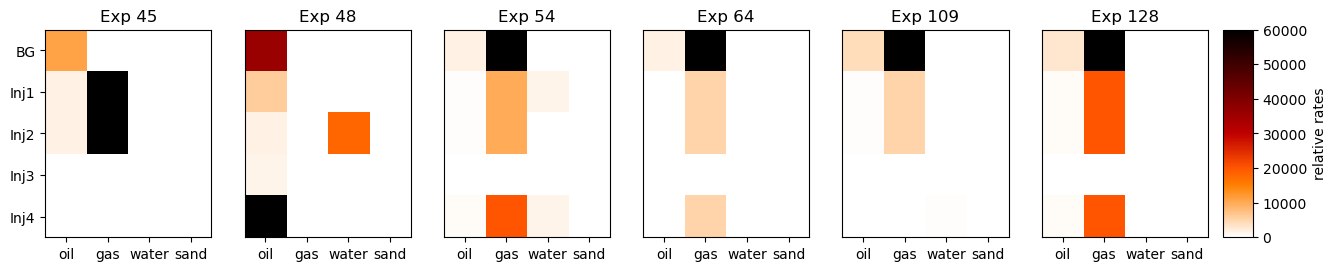

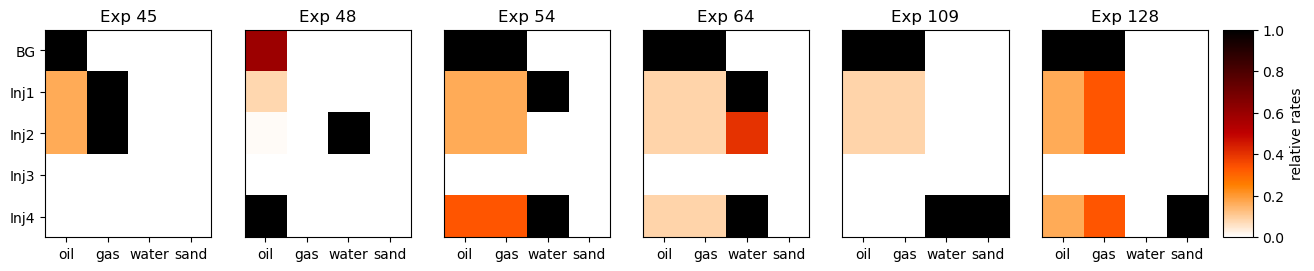

In [5]:
all_flow_orig = np.array([exp45_flow, exp48_flow, exp54_flow, exp64_flow, exp109_flow, exp128_flow])
all_flow_norm = np.array([flow45_norm, flow48_norm, flow54_norm, 
                          flow64_norm, flow109_norm, flow128_norm])

print('Original: {} | Normalized: {}'.format(all_flow_orig.shape, all_flow_norm.shape))
plot_relative_rates(all_flow_orig, cmap='gist_heat_r')
plot_relative_rates(all_flow_norm, cmap='gist_heat_r')

Individual Flow shapes: (200, 4) (200, 4) (200, 4) (200, 4) (200, 4) (200, 4)


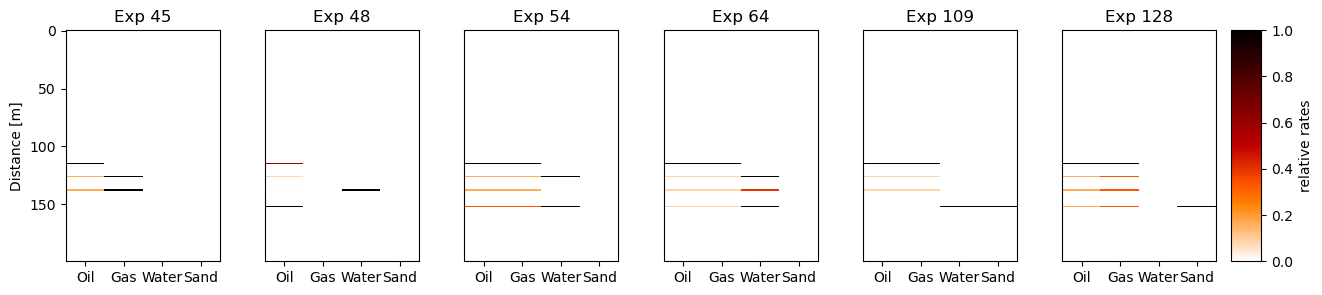

In [6]:
inj_idx = [115, 126, 138, 142, 152]

flow45  = make_sparse_flowrates(all_flow_norm[0], inj_idx)
flow48  = make_sparse_flowrates(all_flow_norm[1], inj_idx)
flow54  = make_sparse_flowrates(all_flow_norm[2], inj_idx)
flow64  = make_sparse_flowrates(all_flow_norm[3], inj_idx)
flow109 = make_sparse_flowrates(all_flow_norm[4], inj_idx)
flow128 = make_sparse_flowrates(all_flow_norm[5], inj_idx)
flow = np.array([flow45, flow48, flow54, flow64, flow109, flow128])

print('Individual Flow shapes:', flow45.shape, flow48.shape,  flow54.shape, 
                                 flow64.shape, flow109.shape, flow128.shape)
plot_relative_mat(flow, cmap='gist_heat_r')

In [ ]:
das45,  dts45  = make_daslhs_dts('45')
das48,  dts48  = make_daslhs_dts('48')
das54,  dts54  = make_daslhs_dts('54')
das64,  dts64  = make_daslhs_dts('64')
das109, dts109 = make_daslhs_dts('109')
das128, dts128 = make_daslhs_dts('128')

print('45  - DAS: {} | DTS: {} | Flow: {}'.format(das45.shape, dts45.shape, flow45.shape))
print('128 - DAS: {} | DTS: {} | Flow: {}'.format(das128.shape, dts128.shape, flow128.shape))

In [ ]:
plot_das_dts_flow(das45,  dts45,  flow45,  expnum='45')
plot_das_dts_flow(das128, dts128, flow128, expnum='128')

***

In [ ]:
das_m2m, das_m2z = das_Unet()
print('AutoEncoder # of parameters: {:,}'.format(das_m2m.count_params()))
print('    Encoder # of parameters: {:,}'.format(das_m2z.count_params()))

das_m2m.compile(optimizer=Nadam(1e-3), loss='mse', metrics=['mse'])
fit_das = das_m2m.fit(das45, das45,
                        shuffle          = True,
                        epochs           = 150,
                        batch_size       = 10,
                        validation_split = 0.2,
                        verbose          = 0)
plot_loss(fit_das, figsize=(4,3))

das45_pred = das_m2m.predict(das45).squeeze().astype('float64')
das45_z = das_m2z.predict(das45).squeeze().astype('float64')
print('SSIM = {:.2f}'.format(100*image_ssim(das45.squeeze().T, das45_pred.T, data_range=1.0)))
print('MSE  = {:.3e}'.format(image_mse(das45.squeeze().T, das45_pred.T)))
print('PSNR = {:.2f}'.format(image_psnr(das45.squeeze().T, das45_pred.T, data_range=2)))

plot_true_pred_z(das45, das45_pred, das45_z, filenum='45 DAS')

In [ ]:
dts_m2m, dts_m2z = dts_Unet()
print('AutoEncoder # of parameters: {:,}'.format(dts_m2m.count_params()))
print('    Encoder # of parameters: {:,}'.format(dts_m2z.count_params()))

dts_m2m.compile(optimizer=Nadam(1e-3), loss='mse', metrics=['mse'])
fit_dts = dts_m2m.fit(dts45, dts45,
                        shuffle          = True,
                        epochs           = 150,
                        batch_size       = 10,
                        validation_split = 0.2,
                        verbose          = 0)
plot_loss(fit_dts, figsize=(4,3))

dts45_pred = dts_m2m.predict(dts45).squeeze().astype('float64')
dts45_z = dts_m2z.predict(dts45).squeeze().astype('float64')
print('SSIM = {:.2f}'.format(100*image_ssim(dts45.squeeze().T, dts45_pred.T, data_range=1.0)))
print('MSE  = {:.3e}'.format(image_mse(dts45.squeeze().T, dts45_pred.T)))
print('PSNR = {:.2f}'.format(image_psnr(dts45.squeeze().T, dts45_pred.T, data_range=2)))

plot_true_pred_z(dts45, dts45_pred, dts45_z, filenum='45 DTS')

***

In [ ]:
make_flowpred_from_dual_latent(das45_z, dts45_z, flow45, expnum='45', method=Ridge())

In [ ]:
# Transfer Learning
transfer_learning_predictions_dual(das128, dts128, flow128, das_m2z, dts_m2z, expnum='128', method=Ridge())

***
## Make Dictionaries from data and models

In [ ]:
flow_dict = {'45':flow45, '48':flow48, '54':flow54, '64':flow64, '109':flow109, '128':flow128}

In [ ]:
models = {'das': {'m2m':das_m2m, 'm2z':das_m2z},
          'dts': {'m2m':dts_m2m, 'm2z':dts_m2z}}

In [ ]:
all_data = {'das': {'45':das45, '48':das48, '54':das54, '64':das64, '109':das109, '128':das128}, 
            'dts': {'45':dts45, '48':dts48, '54':dts54, '64':dts64, '109':dts109, '128':dts128}}

***
## Single Latent Space

In [ ]:
single_latents = make_single_latents(models, all_data)

In [ ]:
make_flowpred_from_single_latent(single_latents, flow_dict, expnum='54', method=Ridge())

***
## Uncertainty Quantification

In [ ]:
make_uq_pred_dual('128', all_data, models, flow_dict)

***
# END